In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import gymnasium as gym
import enflow as ef
import treewe as tr

### Step 1) Define the energy system 

In [2]:
tr.list_problems()

['gefcom2014-wind', 'gefcom2014-solar']

In [3]:
dataset = tr.load_dataset("gefcom2014-solar")

In [4]:
portfolio = dataset.collection
portfolio.draw_tree(show_type=True)

Portfolio (edm.Portfolio)
├── Site1 (edm.PVSystem)
├── Site2 (edm.PVSystem)
└── Site3 (edm.PVSystem)


### Step 2) Define state, exogeneous and action spaces

In [5]:
state_space = ef.DataFrameSpace({asset.name: {
    'U10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'U100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'Power': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
} for asset in portfolio.assets})

n_quantiles = 99

action_space = ef.DataFrameSpace({asset.name: {
    f"Quantile_forecast_{i+1}": gym.spaces.Box(low=0, high=1, shape=(1,)) for i in range(n_quantiles)
} for asset in portfolio.assets})


In [6]:
state_space.sample(n_rows=5)

Site1                                             Site2            \
      Power       U10      U100       V10      V100     Power       U10   
0  0.946157  0.872568  1.918161  0.679294  0.554003  0.752017  2.156646   
1  0.842813  0.814926  1.552320  0.795922 -0.666020  0.897859 -0.609843   
2  0.672188  0.650722 -0.534425 -1.402143  0.270018  0.922471  0.879018   
3  0.729990 -0.445885 -0.566517  0.025771  0.429618  0.227908  1.193250   
4  0.706454  0.603499  1.831674  0.699445  1.306648  0.984941  1.497055   

                                    Site3                                \
       U100       V10      V100     Power       U10      U100       V10   
0 -0.244012 -0.014646 -0.762004  0.319588 -0.116092 -0.639244 -0.941317   
1 -0.221578 -0.240735 -0.458138  0.063978  0.970534  0.606357 -0.614995   
2 -1.293308 -0.481714  1.746512  0.797113  0.691474 -0.195379  0.521748   
3 -0.499305  0.902524  0.090542  0.116211  1.354220  1.777641  1.224313   
4  0.588206 -0.913509 -1.551628  0.387697 -0.020062 -1.248434 -0.154846   

             
       V100  
0  0.141345  
1 -0.422113  
2 -0.357494  
3  1.994142  
4  0.117674

In [7]:
action_space.sample(n_rows=3)

Site1                                            \
  Quantile_forecast_1 Quantile_forecast_10 Quantile_forecast_11   
0            0.535621             0.611244             0.270265   
1            0.580119             0.433710             0.011698   
2            0.095705             0.595996             0.939558   

                                                                  \
  Quantile_forecast_12 Quantile_forecast_13 Quantile_forecast_14   
0             0.857656             0.072695             0.717443   
1             0.086469             0.214754             0.577732   
2             0.812795             0.633175             0.916422   

                                                                  \
  Quantile_forecast_15 Quantile_forecast_16 Quantile_forecast_17   
0             0.598547             0.596392             0.137898   
1             0.340514             0.544251             0.296789   
2             0.149766             0.238178             0.521275   

                        ...                Site3                       \
  Quantile_forecast_18  ... Quantile_forecast_90 Quantile_forecast_91   
0             0.340505  ...             0.649208             0.988674   
1             0.318547  ...             0.865068             0.277567   
2             0.587234  ...             0.409480             0.205605   

                                                                  \
  Quantile_forecast_92 Quantile_forecast_93 Quantile_forecast_94   
0             0.388445             0.313115             0.782385   
1             0.661800             0.874084             0.326299   
2             0.139910             0.283495             0.681415   

                                                                  \
  Quantile_forecast_95 Quantile_forecast_96 Quantile_forecast_97   
0             0.784616             0.967526             0.997752   
1             0.343199             0.791487             0.806606   
2             0.396814             0.185057             0.476785   

                                             
  Quantile_forecast_98 Quantile_forecast_99  
0             0.923837             0.558993  
1             0.451980             0.866115  
2             0.369044             0.327544  

[3 rows x 297 columns]

### Step 3) Create environment

In [8]:
class GEFCom2014SolarEnv(gym.Env):
    def __init__(self, dataset: ef.Dataset, test_month, n_training_months): 
        self.dataset = dataset
        self.data = dataset.data["data_gefcom2014_solar"]
        self.scores = dataset.data["scores_gefcom2014_solar"]
        self.input = ['VAR134', 'VAR157', 'VAR164', 'VAR165', 'VAR166', 'VAR167', 'VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR78', 'VAR79']
        self.target = ["Power"]
        self.state_space = state_space
        self.action_space = action_space
        self.test_month = test_month
        self.n_training_months = n_training_months
        self.idx_counter = 0

        self._generate_train_test()
        self.n_steps = len(self.test)

    def _generate_train_test(self):
        self.train = []
        self.test = []
        test_start = pd.to_datetime(self.test_month + "-01") + pd.DateOffset(hours=1)
        test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(hours=1)
        train_end = test_start - pd.DateOffset(hours=1)
        for n in range(1, self.n_training_months+1): 
            train_start = train_end - pd.DateOffset(months=n) + pd.DateOffset(hours=1)
            if train_start < self.data.index[0][1]:
                break
            self.train.append([train_start, train_end])
            self.test.append([test_start, test_end])

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        training_data = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                      (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]

        first_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                     pd.IndexSlice[:, self.input]]

        return first_input, training_data

    def step(self, action=None):
        self.idx_counter += 1

        if self.idx_counter < self.n_steps:
            next_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                        pd.IndexSlice[:, self.input]] 
            
            previous_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter-1][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter-1][1]),
                                            pd.IndexSlice[:, self.target]]
            
            training_data = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]
            
            done = False
        
        elif self.idx_counter == self.n_steps:
            previous_target = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter-1][0]) &
                                        (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter-1][1]),
                                            pd.IndexSlice[:, self.target]]
            
            training_data = None
            next_input = None
            done = True
        
        return next_input, previous_target, training_data, done
        
    def plot_results(self, losses, drop_tasks=None, n_top_teams=None, xlim=None):
        df_scores = self.scores
        df_scores = df_scores.assign(**losses)
        df_scores = df_scores.drop(index=drop_tasks)
        df_scores.loc["Overall"] = df_scores.mean()
        teams = list(df_scores.drop(columns=losses.keys()).loc["Overall",:].sort_values().iloc[:n_top_teams].index.values)
        teams.extend(losses.keys())
        ax = df_scores.loc[::-1,teams].plot.barh(title="Pinball loss GEFCom20214")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        if xlim: ax.set_xlim(0, xlim)

        return ax

    def plot_forecasts(self, training_target, df_predictions, site="Site1"): 
        import pandas as pd
        import plotly.graph_objects as go
        df = df_predictions.droplevel(0).loc[:,"Site1"]
        df_target = training_target.loc[df.index[0]:df.index[-1],:].droplevel(0).loc[:,"Site1"]

        # Sort quantiles to ensure outer quantiles are filled first
        quantile_columns = [col for col in df.columns if col.startswith('quantile')]
        quantile_columns.sort(key=lambda x: float(x.split('_')[1]))

        # Create the figure
        fig = go.Figure()

        # Loop over the quantiles and add shaded areas
        # Start from the outermost quantiles and move inward
        for i in range(len(quantile_columns) // 2):
            upper_quantile = quantile_columns[-(i+1)]
            lower_quantile = quantile_columns[i]
            
            # Add the upper quantile line (invisible)
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[upper_quantile],
                mode='lines',
                line=dict(color='rgb(0, 0, 255)', width=0),  # No line for the upper bound
                fill=None,
                showlegend=False,
                hoverinfo='skip',  # This disables the hover tooltip
                name=f'{upper_quantile}'
            ))
            
            # Add the lower quantile line and fill the area between the two traces
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[lower_quantile],
                mode='lines',
                line=dict(width=0),  # No line for the lower bound
                fill='tonexty',  # Fill between this trace and the previous one
                fillcolor=f'rgba(0, 0, 255, {0.1 + i * 0.1})',  # Increasing opacity for each quantile band
                showlegend=False,
                hoverinfo='skip',  # This disables the hover tooltip
                name=f'{lower_quantile}'
            ))

        fig.add_trace(go.Scatter(
            x=df.index,
            y=df["quantile_50"],
            mode='lines',
            line=dict(color='blue', width=1),  # Central forecast line
            showlegend=False,
            name='Median'
        ))

        fig.add_trace(go.Scatter(
            x=df_target.index,
            y=df_target["Power"],
            mode='lines',
            line=dict(color='rgba(200, 0, 0, 0.5)', width=2),  # Central forecast line
            showlegend=False,
            name='Power'
        ))

        # Customize layout
        fig.update_layout(
            title='GEFCom2014 Wind Power Forecast',
            xaxis_title='Time',
            yaxis_title='Value',
            hovermode="x"
        )

        # Add range slider
        fig.update_layout(
            xaxis=dict(
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        # Show the plot
        fig.show()


### Step 4) Define the objective


In [9]:
from enflow.problems.objective import PinballLoss

obj = PinballLoss(quantiles=[0.1, 0.5, 0.9])

### Step 5) Create the model


In [10]:
import lightgbm as lgb
import pandas as pd
from contextlib import nullcontext

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, name=None, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """
        self.name = name
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = quantiles
    
    def preprocess(self, df_features: pd.DataFrame) -> pd.DataFrame:
        
        # Reassign df to a copy only within the function scope
        df_features = df_features.copy()

        # Differentiate accumulated features
        features_accum = ['VAR169', 'VAR175', 'VAR178', 'VAR228']
        df_accum = df_features.loc[:,(slice(None),features_accum)]
        df_accum = df_accum.diff()
        df_accum[df_accum.index.get_level_values(1).hour==1] = df_features.loc[df_accum.index.get_level_values(1).hour==1,(slice(None),features_accum)]
        df_accum.loc[:,(slice(None),features_accum[:3])] = df_accum.loc[:,(slice(None),features_accum[:3])]/3600 # Convert from J to Wh/h
        df_features.loc[:,(slice(None),features_accum)] = df_accum 
    
        return df_features

        """
        ra =  Ra(longitude=coords[0],
                latitude=coords[1],
                altitude=alt,
                capacity=cap,
                orientation=orien,
                tilt=tilt)

        df_solpos = ra.calculate_solpos(df[str(i+1)].index)
        df_clearsky = ra.calculate_clearsky(df[str(i+1)].index)
        df_power_clearsky = ra.calculate_power_clearsky(df[str(i+1)].index)
        df_weather = ra.weather_from_ghi(df.loc[:,(str(i+1),'VAR169')])
        df_power = ra.calculate_power(df_weather.copy())

        df_solpos = df_solpos.loc[:, ['zenith', 'azimuth']]
        df_clearsky.columns = df_clearsky.columns+'_clearsky'
        df_weather = df_weather.loc[:, ['dni', 'dhi', 'ghi', 'kt']]
        """

    def train(self, df_features: pd.DataFrame, target: pd.DataFrame, show_progress=True, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """

        df_features = self.preprocess(df_features)

        # Get the list of unique sites from the multi-index (top level)
        sites = df_features.columns.get_level_values(0).unique()
        feature_names = df_features.columns.get_level_values(1).unique()

        pbar = tqdm(total=len(sites)*len(self.quantiles), mininterval=0, desc=f"Training {self.name}") if show_progress else nullcontext()

        with pbar as progress: 
            # Loop over each site
            for site in sites:
                # Extract the features and target for the current site
                site_features = df_features.xs(site, axis=1, level=0)
                site_target = target.xs(site, axis=1, level=0)

                # Loop over each quantile
                for quantile in self.quantiles:
                    # Initialize a LightGBM model for this quantile
                    params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                    params.update(kwargs)  # Add any additional LightGBM parameters
                    
                    model = lgb.LGBMRegressor(**params)
                    
                    # Train the model on the site's data
                    model.fit(site_features, site_target)
                    
                    # Store the trained model with a key (site, quantile)
                    self.models[(site, quantile)] = model

                    if show_progress: 
                        progress.update(1)

    def predict(self, df_features: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            df_features (pd.DataFrame): The feature dataframe (X), multi-indexed column by site.
        
        Returns:
            pd.DataFrame: Predictions from the model.
        """

        df_features = self.preprocess(df_features)

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = df_features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = df_features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        df_predictions = pd.DataFrame.from_dict(predictions)
        df_predictions.index = df_features.index
        
        return df_predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [ ]:
n_test_months = 6
n_training_months = 18
months = pd.date_range(end="2014-06", periods=n_test_months, freq='MS')
months = months.strftime("%Y-%m").tolist()

obj = PinballLoss(quantiles=[0.5])

losses_i = []
if "pbar" in globals(): pbar.close();
pbar = tqdm(total=n_test_months*n_training_months, mininterval=0, leave=False)
for i, month in enumerate(months): 
    env = GEFCom2014SolarEnv(dataset=dataset, test_month=month, n_training_months=n_training_months)
    next_input, training_data = env.reset()
    model = LGBGEFCom2014Predictor(name="predictor", quantiles=[0.5])

    losses_j = []
    for j in range(env.n_steps):
        pbar.set_description(f"Test month: {month}. Training months: {j+1}. ")

        training_input = training_data.loc[:,(slice(None), env.input)]
        training_target = training_data.loc[:,(slice(None), env.target)]
        model.train(df_features=training_input, target=training_target, show_progress=False)
        prediction = model.predict(df_features=next_input)
        next_input, previous_target, training_data, done = env.step()

        loss = obj.calculate(previous_target, prediction, mean=False)
        losses_j.append(np.nanmean(loss, axis=(0,2)))

        pbar.update(1)

    losses_i.append(np.stack(losses_j, axis=-1))
    
losses = np.stack(losses_i, axis=-1)

Test month: 2014-06. Training months: 18. : 100%|██████████| 108/108 [02:22<00:00,  1.43s/it]

In [12]:
import matplotlib.pyplot as plt

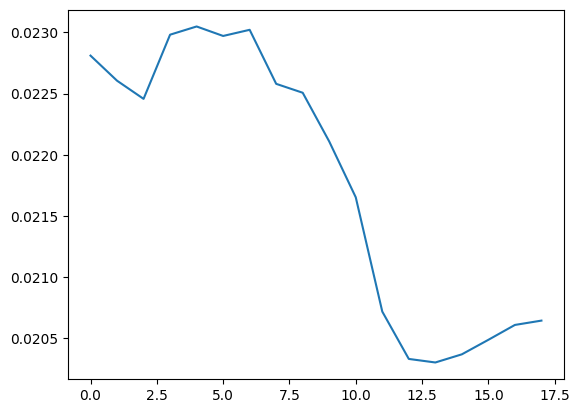

In [30]:
plt.plot(losses.mean(axis=0).mean(axis=1))

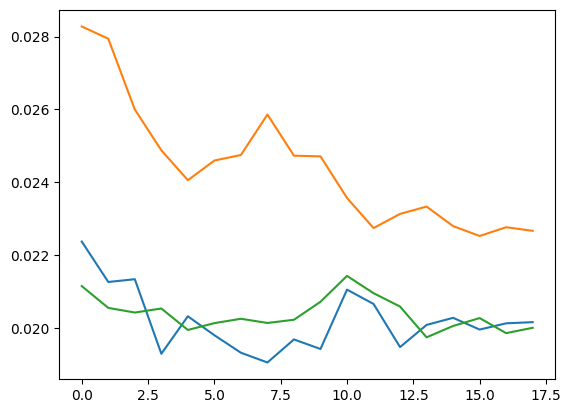

In [28]:
plt.plot(losses[:,:,1].T)